In [31]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split

import sys

In [2]:
# Mount drive to avoid having to reupload experiment.py and model.py
from google.colab import drive
drive.mount("/content/drive")

# Add experiment.py and model.py location
sys.path.append("/content/drive/My Drive/Colab Notebooks/Deep_Learning_SU/Paper_Implementations/ViT")

from experiment import Experiment
from model import VisionTransformer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Step 1: Get data
We will be using the Oxford flowers dataset.

#### Dataset Description

The Oxford Flowers 102 dataset is an image classification dataset consisting of 102 flower categories. The flowers chosen are flowers commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images.

The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The dataset contains 8189 images in total split in the following way:
* Training set: 1020 images (10 images per class x 102 classes)
* Validation set: 1020 images (10 images per class x 102 classes)
* Test set: 6149 images (approximately 60 images per class x 102 classes)

In [4]:
sample_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()           # Convert the image to a tensor
])

In [5]:
sample_images =  datasets.Flowers102(root = "data",
                                     split = "train",
                                     download = True,
                                     transform = sample_transform)

In [6]:
num_classes = len(set(sample_images._labels))
num_classes

102

In [7]:
# Check the first image and label in the data
image = sample_images[0][0]
label = sample_images[0][1]

# Prints image shape
print(f"Image shape is {image.shape} [channels, height, widht]")
# Print image label
print(f"Image label is {label}")

Image shape is torch.Size([3, 224, 224]) [channels, height, widht]
Image label is 0


torch.Size([3, 224, 224])


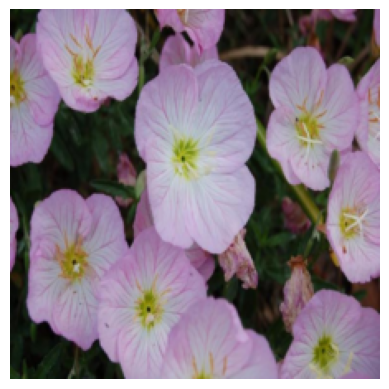

In [8]:
# Visualize image
image_permuted =image.permute(1, 2, 0)
print(f"{image.shape}")
image_permuted_np = np.array(image_permuted)
plt.imshow(image_permuted_np)
plt.axis("Off")
plt.show()

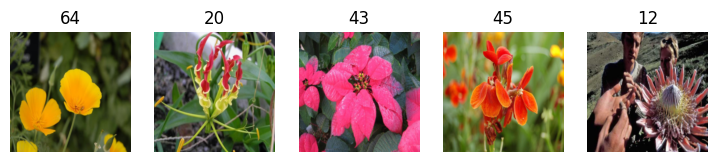

In [9]:
# Plot visualize five random samples from train data
torch.manual_seed(42)
fig = plt.figure(figsize = (9, 9))
rows, cols = 1, 5
for i in range(1, rows * cols +  1):
    random_idx = torch.randint(0, len(sample_images), size= [1]).item()
    img, label = sample_images[random_idx]
    img_permuted = img.permute(1, 2, 0)
    img_np = np.array(img_permuted)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_np)
    plt.title(label)
    plt.axis(False)

#### How we will use the dataset

We will not be using the default train, test and validation splits of the dataset. Rather, we will consolidate the dataset, shuffle it ensure no order biases are present and define our own test, train and validation splits. We have calculate the mean and the standard deviation for the whole Oxdford flowers dataset in a separate notbook. The mean is $[0.436, 0.378, 0.288]$ and the standard deviation is $[0.288, 0.237, 0.253]$.

In [10]:
# Define transform
basic_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.436, 0.378, 0.288],  std = [0.288, 0.237, 0.253])])

In [11]:
# Load the Oxford Flowers 102 dataset
default_train_data = datasets.Flowers102(root = "data",
                                 split = "train",
                                 download = True,
                                 transform = basic_transform)
default_val_data = datasets.Flowers102(root = "data",
                                split= "val",
                                download = True,
                                transform = basic_transform)
default_test_data = datasets.Flowers102(root = "data",
                                split= "test",
                                download = True,
                                transform = basic_transform)

In [12]:
# Check results
len(default_train_data), len(default_val_data), len(default_test_data)

(1020, 1020, 6149)

In [13]:
# Check image datype
type(default_train_data[0][0])

torch.Tensor

In [14]:
# Check shape
default_train_data[0][0].shape

torch.Size([3, 224, 224])

In [15]:
# Check class datatype
type(default_train_data[0][1])

int

In [16]:
# Concat all data
all_flower_images = ConcatDataset([default_train_data, default_val_data, default_test_data])
len(all_flower_images)

8189

In [17]:
# Extract labels from the entire dataset
all_labels = np.array(
    [label for dataset in all_flower_images.datasets for label in dataset._labels]
)
len(all_labels)

8189

In [18]:
# Split the dataset into custom train, validate and test splits
# Generate indices for all samples
indices = np.arange(len(all_flower_images))

# Split into training (80%) and temporary (20%)
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    indices, all_labels, test_size = 0.2, stratify = all_labels, random_state = 42
)

# Split temporary into validation (10%) and test (10%)
val_indices, test_indices = train_test_split(
    temp_indices, test_size = 0.5, stratify = temp_labels, random_state = 42
)

# Create subsets for train, validation, and test
train_data = Subset(all_flower_images, train_indices)
val_data = Subset(all_flower_images, val_indices)
test_data = Subset(all_flower_images, test_indices)

len(train_data), len(val_data), len(test_data)

(6551, 819, 819)

In [19]:
# Function to extract and plot class distribution
def plot_class_distribution(data, split_name):
    # Extract labels
    labels = [label for _, label in data]

    # Plot the class distribution using seaborn
    plt.figure(figsize=(10, 6))
    plt.hist(labels, bins = 102)
    plt.title(f"Class Distribution in {split_name} Split")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation = 90)  # Rotate x-axis labels for better visibility
    plt.show()

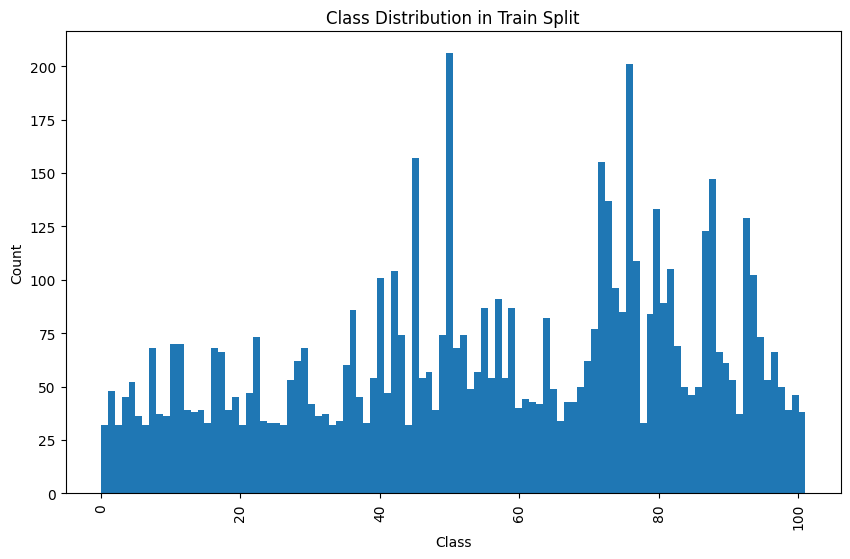

In [20]:
# Plot the distributions for train, val
plot_class_distribution(train_data, "Train")

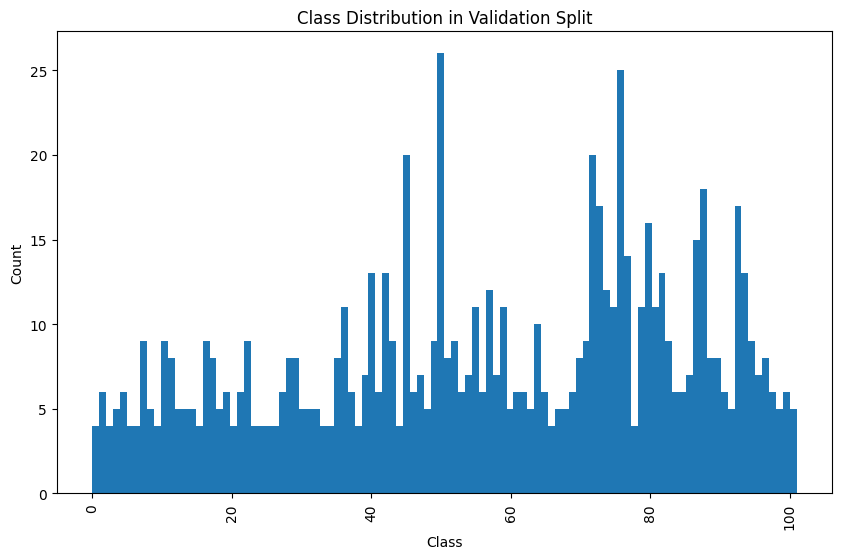

In [21]:
# Plot the distributions for validation split
plot_class_distribution(val_data, "Validation")

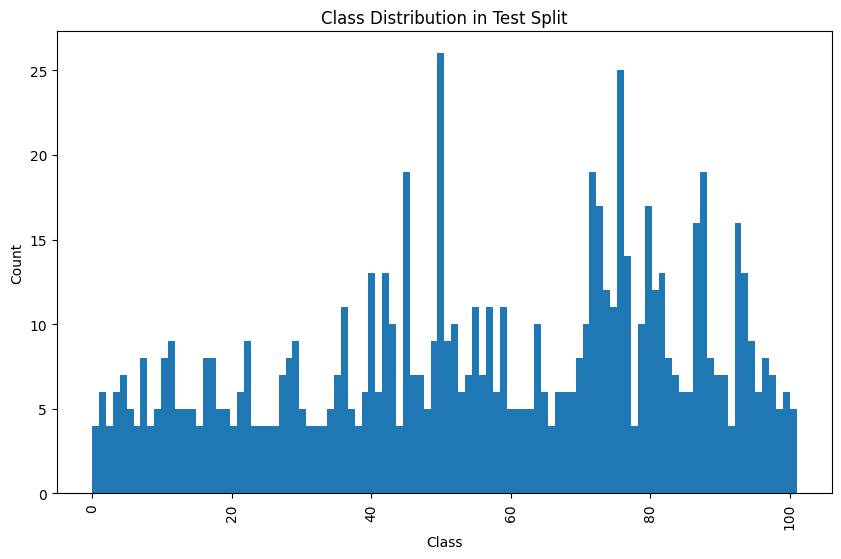

In [22]:
# Plot the distributions for validation split
plot_class_distribution(test_data, "Test")

In [23]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
valid_loader = DataLoader(val_data, batch_size = 32)
test_loader = DataLoader(test_data, batch_size = 32)

### Step 2: Define Model
We will be using the Vision Transformer Model we impemented in the vision_transformer.ipynb notebook.

In [24]:
# Define model
vision_transformer_v1 = VisionTransformer(attn_dropout = 0.0, mlp_dropout = 0.0, embedding_dropout = 0.0, num_classes = num_classes)

In [25]:
# Set up loss and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = vision_transformer_v1.parameters(), lr = 0.01, momentum = 0.9)

### Step 3: Run Experiment (train)

First we will try to overfit a subset of the training dataset.

In [26]:
train_data = train_data.dataset

# Select a subset of indices
train_subset_indices = list(range(500))

# Select subset
train_subset = Subset(train_data, train_subset_indices)
print(f"Train subset consists of {len(train_subset)} images")

# Create a new loader for the train subset
train_subset_loader = DataLoader(train_subset, batch_size = 32, shuffle = True)

Train subset consists of 500 images


Validation loss should be ignored since the subset of the training set is created without stratified sampling.

In [27]:
# Create experiment
experiment_1 = Experiment(
    model = vision_transformer_v1,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_subset_loader,
    val_loader = valid_loader,
    device = device,
    warmup_steps = 0,
    decay_scheduler = None,
    experiment_name = "experiment1",
    experiment_note = "optim - SGD(lr = 0.01, momentum = 0.9), dropout - off, attempting to overfit subset of training set ",
    compute_metrics = False
)

In [28]:
# Run experiment
experiment_1.train(epochs = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 4.2968 | Validation Loss: 5.324825
Epoch [2/50], Train Loss: 3.5568 | Validation Loss: 6.211490
Epoch [3/50], Train Loss: 3.4138 | Validation Loss: 6.199804
Epoch [4/50], Train Loss: 3.3300 | Validation Loss: 6.346005
Epoch [5/50], Train Loss: 3.1535 | Validation Loss: 6.395180
Epoch [6/50], Train Loss: 3.1023 | Validation Loss: 6.347025
Epoch [7/50], Train Loss: 3.0281 | Validation Loss: 6.243855
Epoch [8/50], Train Loss: 2.8938 | Validation Loss: 6.506482
Epoch [9/50], Train Loss: 2.8401 | Validation Loss: 6.561706
Epoch [10/50], Train Loss: 2.7254 | Validation Loss: 6.626393
Epoch [11/50], Train Loss: 2.5832 | Validation Loss: 6.780389
Epoch [12/50], Train Loss: 2.4513 | Validation Loss: 7.150270
Epoch [13/50], Train Loss: 2.5414 | Validation Loss: 6.668522
Epoch [14/50], Train Loss: 2.4054 | Validation Loss: 7.048443
Epoch [15/50], Train Loss: 2.2089 | Validation Loss: 7.099958
Epoch [16/50], Train Loss: 2.2945 | Validation Loss: 6.732180
Epoch [17/50], Tr

In [29]:
del vision_transformer_v1
del experiment_1

Ok, let us try training on the whole training dataset with the adam optimizer.

In [33]:
# Reinstantiate model
vision_transformer_v1 = VisionTransformer(attn_dropout = 0.0, mlp_dropout = 0.0, embedding_dropout = 0.0, num_classes = num_classes)

# Swith to the Adam optimizer
optimizer = torch.optim.Adam(params = vision_transformer_v1.parameters(), lr = 3e-3, betas = (0.9, 0.999))

# StepLR scheduler with decay every 10 epochs
scheduler = StepLR(optimizer, step_size = 10, gamma = 0.1)

# Create experiment
experiment_2 = Experiment(
    model = vision_transformer_v1,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = valid_loader,
    device = device,
    warmup_steps = 100,
    decay_scheduler = scheduler ,
    experiment_name = "experiment2",
    experiment_note = "optim - Adam(lr = 3e-3, betas = (0.9, 0.999)), dropout - off, warmup + decay",
    compute_metrics = False
)

In [ ]:
# Run experiment
experiment_2.train(epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 4.4964 | Validation Loss: 4.410068
Epoch [2/20], Train Loss: 4.4413 | Validation Loss: 4.408435
Epoch [3/20], Train Loss: 4.4269 | Validation Loss: 4.395657
Epoch [4/20], Train Loss: 4.4217 | Validation Loss: 4.403746
Epoch [5/20], Train Loss: 4.4196 | Validation Loss: 4.390739
Epoch [6/20], Train Loss: 4.4167 | Validation Loss: 4.387255
Epoch [7/20], Train Loss: 4.4158 | Validation Loss: 4.388919
